# Error Visualization

- Quantifying Errors
	- From Determined Test Cases,  
For each word, measure the number of *correctly* and *incorrectly* interpreted
- Classifying Errors
	- Miss interpretation of the words  
For each word, log the transcription, what is the the misinterpretation of the error  
→ calculate the occurence  
→ most common error for a given word


In [39]:
import os, pathlib
import numpy
import glob
import jiwer
import collections
import helper

# TODO: remove warning, put text preprocessing as helper


In [40]:
class Data:

    def __init__(self, name):
        self.name = name
        self.reference = []
        self.transcription = []
        self.transcription_hash = {}

    def preprocess_text(self, text):
        return helper.preprocess_text(text)

    def get_name(self):
        return self.name
    
    def get_reference(self):
        return self.reference

    def get_transcription(self):
        return self.transcription

    def get_transcription_hash(self, reference):
        return self.transcription_hash[reference]

    def add_reference(self, reference):
        self.reference.append(reference)
    
    def add_transcription(self, transcription):
        self.transcription.append(transcription)

    def add_reference_transcription(self, reference, transcription):
        self.add_reference(reference)
        self.add_transcription(transcription)
        self.transcription_hash[reference] = transcription
    
    def length(self):
        assert len(self.reference) == len(self.transcription)
        return len(self.reference)

    def print_reference_transcription(self, i):
        if i >= 0 and i < len(self.reference):
            print("Reference:   \t: ", self.reference[i])
            print("Transcription: \t: ", self.transcription[i])

    
    def print_head(self):
        self.print_reference_transcription(i=0)

    def print_tail(self):
        self.print_reference_transcription(i=self.length()-1)


In [41]:
# LIBRISPEECH_TYPES = ["test-clean",
#                     "test-other",
#                     "dev-clean",
#                     "dev-other",
#                     "train-clean-100",
# ]

# LIBRISPEECH_TYPES = ["test-clean"]

# LIBRISPEECH_TYPES = ["test-other"]

# LIBRISPEECH_TYPES = ["dev-clean"]

# LIBRISPEECH_TYPES = ["dev-other"]
LIBRISPEECH_TYPES = ["train-clean-100"]


LIBRISPEECH_DIRS = []

for type in LIBRISPEECH_TYPES :
    LIBRISPEECH_DIRS.append(f"LibriSpeech/{type}/")


In [42]:
ASR_NAME = "deepspeech"
# ASR_NAME = "wav2vec2"

In [43]:
def read_librispeech_data():
    data = Data("librispeech")

    
    for librispeech_dir in LIBRISPEECH_DIRS:
        # librispeech_dir = "LibriSpeech/test-clean/"

        for filename in glob.iglob(librispeech_dir + '**/*.trans.txt', recursive=True):
            
            file = open(filename)

            for line in file.readlines():
                idx = line.split()[0]
                reference_text = " ".join(line.split()[1:])
                

                fid = "/".join(idx.split("-")[:-1]) # idx to file id

                fname = os.path.join(librispeech_dir, fid, idx)
                transcription_path = fname + "." + ASR_NAME + ".transcription.txt"
                if os.path.exists(transcription_path):
                    transcription = helper.read_transcription(transcription_path)
                    
                    # preprocess the text and transcription
                    reference_text = helper.preprocess_text(reference_text)
                    transcription = helper.preprocess_text(transcription)
                    
                    data.add_reference_transcription(reference_text, transcription)
                else:
                    raise ValueError("missing transcription: " + transcription_path)

            file.close()
        
    
    return data


In [44]:
data = read_librispeech_data()
data.print_head()
print()
data.print_tail()

Reference:   	:  the girl who came into the world on that night when jesse ran through the fields crying to god that he be given a son had grown to womanhood on the farm
Transcription: 	:  the girl who came into the world on that night when jessie ran through the fields crying to god that he be given a son had grown to womanhood on the farm

Reference:   	:  it was difficult to believe that it was the same for it had all been rebuilt and done up again
Transcription: 	:  it was difficult to believe that it was the same for it had all been rebuilt and done up again


In [45]:
CROSSASR_TTS_NAME = "mac"
CROSSASR_TTS_VOICE = "Alex"


In [46]:
def read_corpus(corpus_fpath: str):
    file = open(corpus_fpath)
    corpus = file.readlines()
    texts = []
    for text in corpus:
        texts.append(text[:-1])

    return texts

def read_crossasr_data():
    data = Data("crossasr")

    # mode = "europarl"
    mode = "librispeech"

    corpus_fpaths = []
    transcription_dirs = []
    
    if mode == "europarl" :
        
        corpus_fpath = "CrossASR/europarl-seed2021/corpus/europarl-20000.txt"
        transcription_dir = "CrossASR/europarl-seed2021/data/transcription"
        
        corpus_fpaths.append(corpus_fpath)
        transcription_dirs.append(transcription_dir)
        
    elif mode == "librispeech" :

        for t in LIBRISPEECH_TYPES:
        
            corpus_fpath = f"CrossASR/librispeech-crossasr-{t}/corpus/librispeech-{t}-corpus.txt"
            transcription_dir = f"CrossASR/librispeech-crossasr-{t}/data/transcription"
            
            corpus_fpaths.append(corpus_fpath)
            transcription_dirs.append(transcription_dir)



    for corpus_fpath, transcription_dir in zip(corpus_fpaths, transcription_dirs):
    
        if CROSSASR_TTS_NAME == "mac" :
            transcription_dir = os.path.join(
                transcription_dir, CROSSASR_TTS_NAME, CROSSASR_TTS_VOICE, ASR_NAME)
        else :
            transcription_dir = os.path.join(transcription_dir, CROSSASR_TTS_NAME, ASR_NAME)

        references = read_corpus(corpus_fpath)
        
        for i in range(len(references)):
            if mode == "europarl" :
                transcription_path = os.path.join(transcription_dir, f"{i+1}.txt")
            elif mode == "librispeech" :
                transcription_path = os.path.join(transcription_dir, f"{i}.txt")
            transcription = helper.read_transcription(transcription_path)
            transcription = helper.preprocess_text(transcription)

            data.add_reference_transcription(references[i], transcription)

    return data



In [47]:
data = read_crossasr_data()
data.print_head()
print()
data.print_tail()

Reference:   	:  the girl who came into the world on that night when jesse ran through the fields crying to god that he be given a son had grown to womanhood on the farm
Transcription: 	:  the girl who came into the world on that night when jesse ran through the fields cry to god that he be given a son had grown to womanhood on the farm

Reference:   	:  it was difficult to believe that it was the same for it had all been rebuilt and done up again
Transcription: 	:  it was difficult to believe that it was the same for it had all been rebuilt and done up again


In [48]:
from asr_evaluation.asr_evaluation import asr_evaluation

class Analyzer(object):

    
    def __init__(self):
        ## used for caching
        self.infos = {}
        self.word_count = {}
        self.word_accuracy = {}
        self.word_accuracy_with_count = {}
        self.common_errors = {}

        
    def analyze(self, data: Data):

        ## get from cache if it is already computed before
        if data.get_name() in self.infos :
            return self.infos[data.get_name()], self.word_count[data.get_name()]
        
        infos = []
        word_count = collections.Counter()
        
        for reference, transcription, in zip(data.get_reference(), data.get_transcription()) :
            
            ## create statistics for word counter
            word_count += collections.Counter(reference.split())
            
            ## create statistics for errors
            wer = jiwer.wer(reference, transcription)
            if wer != 0:
                evaluation = asr_evaluation.ASREvaluation()
                evaluation.detect_word_error(reference, transcription)
                confusion = evaluation.get_confusions()
                infos.append(
                    {"confusion": confusion, "reference": reference, "transcription": transcription})
        
        ## update the cache
        self.infos[data.get_name()] = infos
        self.word_count[data.get_name()] = word_count
        
        
        return infos, word_count

    def calculate_word_accuracy(self, data: Data):
        """Calculate word accuracy, which is the number of error (deletion or subsitution) divided by the number of word count

        """

        ## use caching if it is already computed before
        if data.get_name() in self.word_accuracy:
            return self.word_accuracy[data.get_name()]

        
        infos, word_count = self.analyze(data)
        error_count = collections.Counter()
        for info in infos:
            confusion = info["confusion"]

            ## get error from word substitution
            if len(confusion["substitution"]) > 0:
                
                curr_error_count = {}
                for i in range(len(confusion["substitution"])):
                    word_reference = confusion["substitution"][i]["word_reference"]
                    count = confusion["substitution"][i]["count"]

                    curr_error_count[word_reference] = count
                
                error_count += collections.Counter(curr_error_count)

            ## get error from word deletion
            if len(confusion["deletion"]) > 0:

                curr_error_count = {}
                for i in range(len(confusion["deletion"])):
                    word_reference = confusion["deletion"][i]["word"]
                    count = confusion["deletion"][i]["count"]

                    curr_error_count[word_reference] = count

                error_count += collections.Counter(curr_error_count)

        
        word_accuracy = {}
        word_accuracy_with_count = {}
        for word in word_count :
            
            ## if the word in the reference_text does not appear in the error word
            ## then all the occurence of the word is correctly predicted 
            if word not in error_count :
                word_accuracy[word] = 100.0 
                word_accuracy_with_count[word] = [100.0 , word_count[word]]
            else :
                curr_word_accuracy = 100.0 - (100 * round(error_count[word]/word_count[word], 2))
                assert curr_word_accuracy <= 100 and curr_word_accuracy >= 0
                word_accuracy[word] = curr_word_accuracy
                word_accuracy_with_count[word] = [curr_word_accuracy, word_count[word]]

        ## sort the word accuracy based on the word_accuracy
        word_accuracy = dict(sorted(word_accuracy.items(),
                                    key=lambda item: (item[1], item[0]), reverse=True))

        ## sort the word accuracy with count based on the word_accuracy
        word_accuracy_with_count = dict(sorted(word_accuracy_with_count.items(),
                                               key=lambda item: (item[1][0], -item[1][1], item[0]), reverse=False))

        
        ## update cache
        self.word_accuracy[data.get_name()] = word_accuracy
        self.word_accuracy_with_count[data.get_name()] = word_accuracy_with_count
        
        return word_accuracy

    def get_word_accuracy(self, dataset_name:str):
        if dataset_name in self.word_accuracy :
            return self.word_accuracy[dataset_name]
        return None

    def get_word_accuracy_with_count(self, dataset_name: str):
        if dataset_name in self.word_accuracy_with_count:
            return self.word_accuracy_with_count[dataset_name]
        return None


    def print_word_accuracy_with_minimum_count(self, data: Data, limit=0, minimium_count=10, ascending=True):
        
        if not data.get_name() in self.word_accuracy_with_count :
            self.calculate_word_accuracy(data)
        
        word_accuracy_with_count = self.word_accuracy_with_count[data.get_name()]
    
        keys = list(word_accuracy_with_count.keys())
        values = list(word_accuracy_with_count.values())
        print(f"{'Word':15s} {'Accuracy'} \tCount")
        
        j = 0
        for i in reversed(range(len(keys))) if ascending else range(len(keys)):
            if j < limit :
                if values[i][1] >= minimium_count :
                    print(f"{keys[i]:15s} {values[i][0]:} \t\t{values[i][1]:}")
                    j += 1


    def save_word_accuracy(self, dataset_name, fpath):
        word_accuracy = self.word_accuracy[dataset_name]
        os.makedirs(pathlib.Path(fpath).parent.absolute(), exist_ok=True)
        with open(fpath, 'w') as file:
            keys = list(word_accuracy.keys())
            values = list(word_accuracy.values())
            file.write(f"{'Word':15s} \t{'Accuracy'}\n")
            for i in range(len(keys)):
                file.write(f"{keys[i]:15s} \t{values[i]}\n")

    def save_word_accuracy_with_count(self, dataset_name, fpath):
        word_accuracy_with_count = self.word_accuracy_with_count[dataset_name]
        os.makedirs(pathlib.Path(fpath).parent.absolute(), exist_ok=True)
        with open(fpath, 'w') as file:
            keys = list(word_accuracy_with_count.keys())
            values = list(word_accuracy_with_count.values())
            file.write(f"{'Word':15s} \t{'Accuracy'} \tCount\n")
            for i in range(len(keys)):
                file.write(
                    f"{keys[i]:15s} \t{values[i][0]} \t{values[i][1]}\n")

    def print_lowest_word_accuracy(self, dataset_name, limit=10):
        word_accuracy = self.word_accuracy[dataset_name]
        keys = list(word_accuracy.keys())
        values = list(word_accuracy.values())
        print(f"{'Word':15s} {'Accuracy'}")
        for i in range(len(keys)-limit, len(keys)):
            print(f"{keys[i]:15s} {values[i]}")

    def print_highest_word_accuracy(self, dataset_name, limit=10):
        word_accuracy = self.word_accuracy[dataset_name]
        keys = list(word_accuracy.keys())
        values = list(word_accuracy.values())
        print(f"{'Word':15s} {'Accuracy'}")
        for i in range(limit):
            print(f"{keys[i]:15s} {values[i]}")


    def get_most_common_errors(self, data: Data):
        
        
        ## geta result from caching if it is already computed before
        if data.get_name() in self.common_errors:
            return self.common_errors[data.get_name()]


        infos, _ = self.analyze(data)

        ## TODO: use Counter library
        common_errors = {}
        for info in infos:
            confusion = info["confusion"]
            if len(confusion["substitution"]) > 0:
                for i in range(len(confusion["substitution"])):
                    word_reference = confusion["substitution"][i]["word_reference"]
                    word_substitution = confusion["substitution"][i]["word_substitution"]
                    count = confusion["substitution"][i]["count"]

                    if word_reference == "and" and word_substitution == "terrified":
                        print(info["reference"])
                        print(info["transcription"])


                    if word_reference in common_errors:
                        substitutions = common_errors[word_reference]
                        if word_substitution in substitutions:
                            common_errors[word_reference][word_substitution] = count + \
                                common_errors[word_reference][word_substitution]
                        else:
                            common_errors[word_reference][word_substitution] = count
                    else:
                        common_errors[word_reference] = {
                            word_substitution: count}

        ## sort things inside the common error
        for key in common_errors.keys():
            common_errors[key] = dict(sorted(common_errors[key].items(),
                                            key=lambda item: item[1], reverse=True))

        ## sort words based on the highest occurence
        common_errors = dict(sorted(common_errors.items(),
                                        key=lambda item: list(item[1].values())[0], reverse=True))
        
        self.common_errors[data.get_name()] = common_errors
        
        return common_errors

    def print_common_error(self, common_errors, limit=2):
        count = 0
        print_limit = 16
        for word, common in common_errors.items():
            if count < print_limit :
                print("Word: ", word)
                # print("Substituion: ")
                keys = list(common.keys())
                values = list(common.values())
                for i in range(min(limit, len(keys))):
                    print(f"\t{keys[i]:10s} count: {values[i]}")
            count += 1

    def save_common_errors(self, common_errors, fpath):
        os.makedirs(pathlib.Path(fpath).parent.absolute(), exist_ok=True)
        with open(fpath, 'w') as file:
            for word, common in common_errors.items():
                file.write(f"Word: {word}\n")
                keys = list(common.keys())
                values = list(common.values())
                for i in range(len(keys)):
                    file.write(f"\t{keys[i]:10s} count: {values[i]}\n")
            


In [49]:
analyzer = Analyzer()

data = read_librispeech_data()

analyzer.calculate_word_accuracy(data)
word_accuracy = analyzer.get_word_accuracy(data.get_name())

fpath = "output/librispeech/word_accuracy.txt"
analyzer.save_word_accuracy(data.get_name(), fpath)

fpath = "output/librispeech/word_accuracy_with_count.txt"
analyzer.save_word_accuracy_with_count(data.get_name(), fpath)


print("=== Lowest Accuracy Rate")
analyzer.print_lowest_word_accuracy(data.get_name())
print()

print("=== Highest Accuracy Rate")
analyzer.print_highest_word_accuracy(data.get_name())
print()


=== Lowest Accuracy Rate
Word            Accuracy
abnormally      0.0
abigails        0.0
abhorrent       0.0
abhor           0.0
abedare         0.0
abdolmumen      0.0
abdalmalik      0.0
abbots          0.0
abbes           0.0
abbaye          0.0

=== Highest Accuracy Rate
Word            Accuracy
zoologist       100.0
zoo             100.0
zodangans       100.0
zodangan        100.0
zodanga         100.0
zigzags         100.0
zero            100.0
zenza           100.0
zenith          100.0
zenas           100.0



In [50]:
analyzer.print_word_accuracy_with_minimum_count(data, limit=20, minimium_count=10)


Word            Accuracy 	Count
worthless       100.0 		10
willard         100.0 		10
voluntarily     100.0 		10
veteran         100.0 		10
varying         100.0 		10
utility         100.0 		10
unbounded       100.0 		10
tyrant          100.0 		10
twitched        100.0 		10
tumble          100.0 		10
trunks          100.0 		10
tread           100.0 		10
tragic          100.0 		10
touches         100.0 		10
timidly         100.0 		10
thankful        100.0 		10
text            100.0 		10
termed          100.0 		10
temples         100.0 		10
talents         100.0 		10


In [51]:
print("=== Most common errors")
common_errors = analyzer.get_most_common_errors(data)
fpath = "output/librispeech/common_errors.txt"
analyzer.save_common_errors(common_errors, fpath)
analyzer.print_common_error(common_errors)
print()


=== Most common errors
Word:  in
	and        count: 601
	an         count: 24
Word:  a
	the        count: 466
	of         count: 37
Word:  and
	in         count: 355
	an         count: 50
Word:  this
	the        count: 214
	his        count: 30
Word:  an
	and        count: 211
	in         count: 24
Word:  the
	a          count: 165
	that       count: 40
Word:  that
	the        count: 149
	but        count: 49
Word:  their
	the        count: 90
	there      count: 26
Word:  too
	to         count: 87
	two        count: 31
Word:  of
	a          count: 81
	at         count: 18
Word:  im
	am         count: 73
	i          count: 8
Word:  is
	as         count: 67
	was        count: 44
Word:  two
	to         count: 66
	too        count: 16
Word:  than
	then       count: 65
	that       count: 24
Word:  well
	will       count: 58
	while      count: 14
Word:  anne
	and        count: 53
	an         count: 8



In [52]:
data = read_crossasr_data()

# analyzer = Analyzer()
analyzer.calculate_word_accuracy(data)
word_accuracy = analyzer.get_word_accuracy(data.get_name())

fpath = "output/crossasr/word_accuracy.txt"
analyzer.save_word_accuracy(data.get_name(), fpath)

fpath = "output/crossasr/word_accuracy_with_count.txt"
analyzer.save_word_accuracy_with_count(data.get_name(), fpath)


print("=== Lowest Accuracy Rate")
analyzer.print_lowest_word_accuracy(data.get_name())
print()

print("=== Highest Accuracy Rate")
analyzer.print_highest_word_accuracy(data.get_name())
print()


=== Lowest Accuracy Rate
Word            Accuracy
abdolmumen      0.0
abdication      0.0
abdalmalik      0.0
abbots          0.0
abbot           0.0
abbeville       0.0
abbaye          0.0
abated          0.0
abalone         0.0
abaft           0.0

=== Highest Accuracy Rate
Word            Accuracy
zoological      100.0
zoo             100.0
zodangans       100.0
zero            100.0
zee             100.0
zebras          100.0
zealously       100.0
youngsters      100.0
youngster       100.0
yoshitomo       100.0



In [53]:
print("=== Most common errors")

common_errors = analyzer.get_most_common_errors(data)
fpath = "output/crossasr/common_errors.txt"
analyzer.save_common_errors(common_errors, fpath)

analyzer.print_common_error(common_errors)
print()


=== Most common errors
Word:  a
	the        count: 1425
	to         count: 149
Word:  in
	and        count: 1214
	the        count: 52
Word:  and
	in         count: 1149
	the        count: 122
Word:  the
	a          count: 401
	this       count: 319
Word:  an
	and        count: 254
	the        count: 97
Word:  it
	that       count: 181
	a          count: 89
Word:  too
	to         count: 163
	two        count: 41
Word:  him
	them       count: 154
	and        count: 143
Word:  at
	that       count: 149
	a          count: 35
Word:  is
	as         count: 141
	his        count: 71
Word:  that
	the        count: 140
	at         count: 138
Word:  to
	into       count: 129
	a          count: 25
Word:  then
	and        count: 127
	than       count: 105
Word:  didnt
	and        count: 123
	did        count: 67
Word:  he
	you        count: 120
	the        count: 68
Word:  cant
	can        count: 117
	to         count: 4



In [54]:
analyzer.print_word_accuracy_with_minimum_count(
    data, limit=20, minimium_count=10)


Word            Accuracy 	Count
willard         100.0 		10
wheeled         100.0 		10
veteran         100.0 		10
utility         100.0 		10
trunks          100.0 		10
touches         100.0 		10
throckmorton    100.0 		10
talents         100.0 		10
tackle          100.0 		10
superiority     100.0 		10
striped         100.0 		10
statements      100.0 		10
squeezed        100.0 		10
sporting        100.0 		10
split           100.0 		10
singer          100.0 		10
shower          100.0 		10
shepherds       100.0 		10
separating      100.0 		10
sections        100.0 		10


## Insight 

It seems hard to compare the words intersection one-by-one. 
We will try qeurying the statistic for each word that has much error in CrossASR
Then get corresponding statistic from Librispeech data

### Combining Word Accuracy from the Two Results


In [55]:
cr_data = read_crossasr_data()   ## crossasr data
ls_data = read_librispeech_data()   ## librispeech data

analyzer = Analyzer()

analyzer.calculate_word_accuracy(cr_data)
analyzer.calculate_word_accuracy(ls_data)


cr_word_acc = analyzer.get_word_accuracy_with_count(cr_data.get_name())
ls_word_acc = analyzer.get_word_accuracy_with_count(ls_data.get_name())

#### For each error in librispeech word accuracy, inform the corresponding error on the crossasr 

In [56]:
import pandas as pd
df = pd.DataFrame(columns=["word", "ls_word_acc",
                  "cr_word_acc", "ls_word_count",  "cr_word_count"])
for word in ls_word_acc :
    if word in cr_word_acc :
        df = df.append({"word": word,
                        "ls_word_acc": round(ls_word_acc[word][0], 2),
                        "cr_word_acc": round(cr_word_acc[word][0], 2),
                        "ls_word_count": ls_word_acc[word][1],
                        "cr_word_count": cr_word_acc[word][1]
                        }, ignore_index=True)
    else :
        df = df.append({"word": word,
                        "ls_word_acc": round(ls_word_acc[word][0],2), 
                        "cr_word_acc" : -1,
                        "ls_word_count": ls_word_acc[word][1],
                        "cr_word_count": -1
                   }, ignore_index=True)

df


,word,ls_word_acc,cr_word_acc,ls_word_count,cr_word_count
0,kwairyo,0.0,5.0,21,21
1,conniston,0.0,0.0,19,19
2,tromp,0.0,0.0,18,18
3,deasey,0.0,0.0,17,17
4,drouet,0.0,0.0,17,17
...,...,...,...,...,...
33323,zenas,100.0,0.0,1,1
33324,zenith,100.0,0.0,1,1
33325,zodangan,100.0,0.0,1,1
33326,zodangans,100.0,100.0,1,1


In [57]:
## check the row to ensure ls_word_count == cr_word_count
df[df.apply(lambda x: x.ls_word_count != x.cr_word_count, axis=1)]


,word,ls_word_acc,cr_word_acc,ls_word_count,cr_word_count


In [58]:
## filtering non english words

import nltk

english_word_corpus = set(nltk.corpus.words.words())

df = df[df["word"].apply(lambda x: x in english_word_corpus)]


In [59]:
df.to_csv("output/combined_word_accuracy.csv")

## Error Visualization

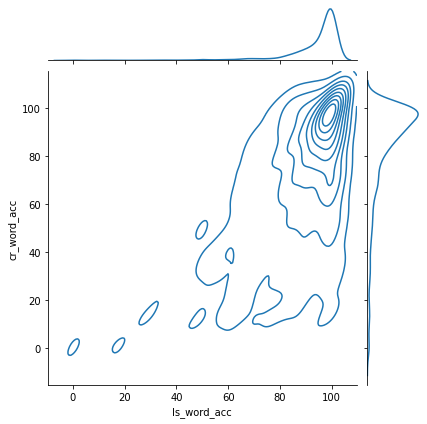

In [60]:
import seaborn as sns
from matplotlib import pyplot as plt


# sns.scatterplot(data=df, x="ls_word_acc", y="cr_word_acc").set(title="Correlation of Word Accuracy")
# sns.jointplot(data=df, x="ls_word_acc", y="cr_word_acc", kind="hist")
# sns.jointplot(data=df, x="ls_word_acc", y="cr_word_acc", kind="kde")
sns.jointplot(data=df[df["ls_word_count"] > 5], x="ls_word_acc", y="cr_word_acc", kind="kde")


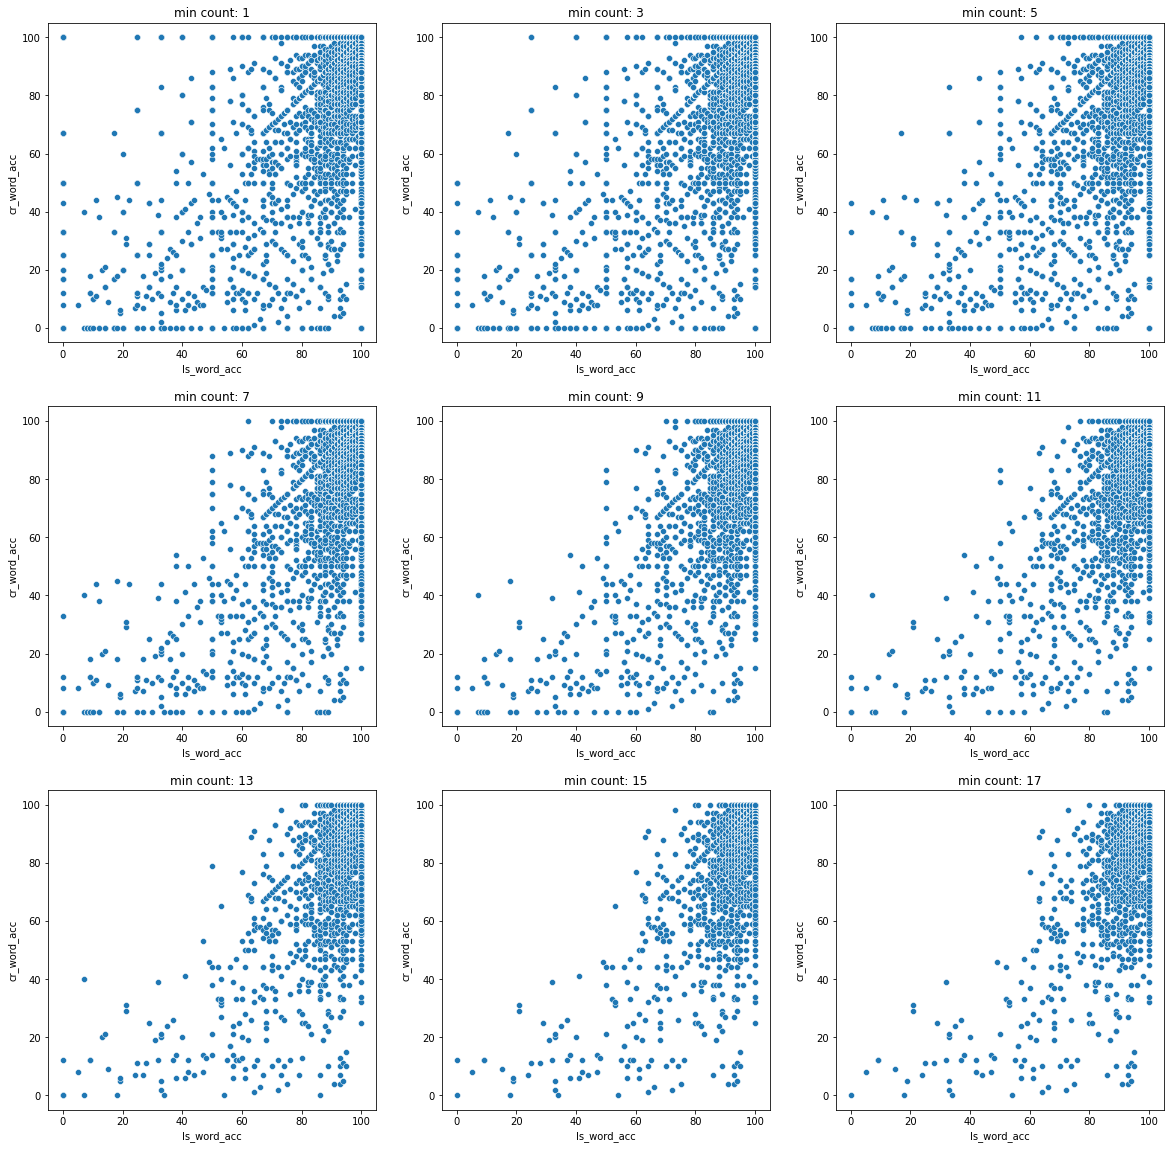

In [61]:
## correlation with minimum count
min_count = [1, 3, 5, 7, 9, 11, 13, 15, 17]

M = 3 
N = 3
fig, axes = plt.subplots(M, N, figsize=(20, 20))

for i in range(M) :
    for j in range(N) :
        k = i*M + j
        sns.scatterplot(ax=axes[i,j], 
                        data=df[df["ls_word_count"] > min_count[k]],
                        x="ls_word_acc", 
                        y="cr_word_acc").set(
                                        title=f"min count: {min_count[k]}")


In [62]:
### try derive more feature by finding the size of occurence
curr_df = df.groupby(["ls_word_acc", "cr_word_acc"]).size().reset_index(name="size")
curr_df


,ls_word_acc,cr_word_acc,size
0,0.0,0.0,1149
1,0.0,8.0,1
2,0.0,12.0,1
3,0.0,17.0,3
4,0.0,20.0,2
...,...,...,...
1106,100.0,96.0,91
1107,100.0,97.0,85
1108,100.0,98.0,62
1109,100.0,99.0,39


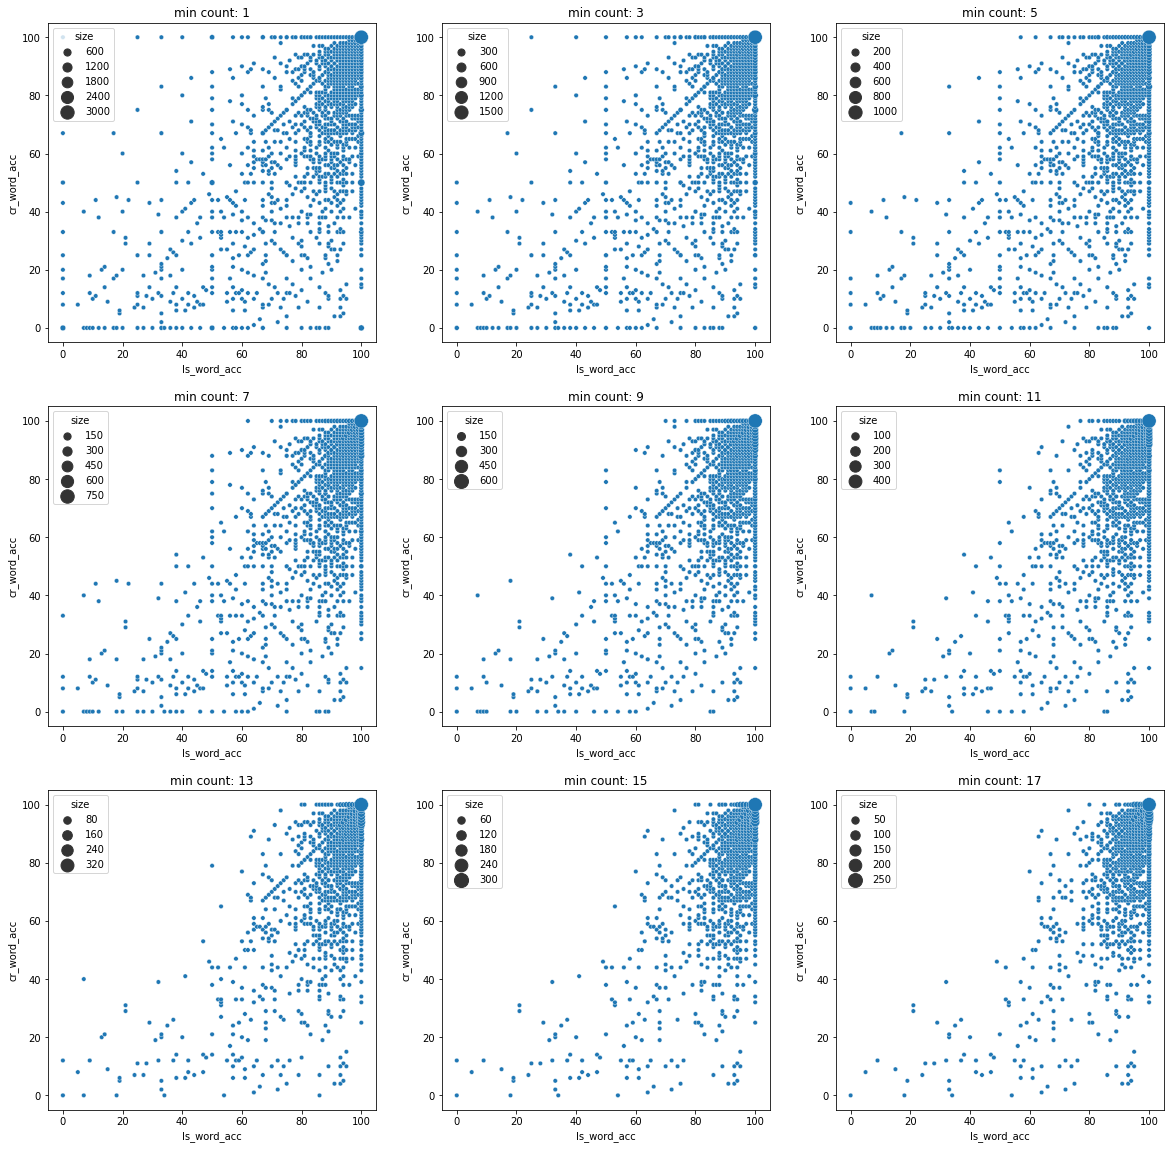

In [63]:
## correlation with minimum count
min_count = [1, 3, 5, 7, 9, 11, 13, 15, 17]

M = 3
N = 3
fig, axes = plt.subplots(M, N, figsize=(20, 20))

for i in range(M):
    for j in range(N):
        k = i*M + j

        curr_df = df[df["ls_word_count"] > min_count[k]]
        curr_df = curr_df.groupby(["ls_word_acc", "cr_word_acc"]
                             ).size().reset_index(name="size")

        sns.scatterplot(ax=axes[i, j],
                        data=curr_df,
                        x="ls_word_acc",
                        y="cr_word_acc", 
                        size="size", sizes=(20, 200)).set(
            title=f"min count: {min_count[k]}")


## Pearson Correlation Test

In [64]:
import scipy

# scipy.stats.pearsonr(df["ls_word_acc"], df["cr_word_acc"])
scipy.stats.mannwhitneyu(df["ls_word_acc"], df["cr_word_acc"])


MannwhitneyuResult(statistic=212873368.0, pvalue=0.0)

In [65]:

stat = pd.DataFrame(columns=["bin_interval", "pearson_corr"]) 


n_bins = [1, 2, 4, 5, 10]

for n_bin in n_bins :
    bin_interval = int(100/n_bin)

    for i in range(n_bin):
        lower_bound = i * bin_interval
        upper_bound = lower_bound + bin_interval
        curr_df = df[df["cr_word_acc"].apply(
            lambda x: x >= lower_bound and x < upper_bound)]
        stat = stat.append(
            {
                "bin_interval": f"{int(lower_bound)}-{int(upper_bound)}",
                "pearson_corr": scipy.stats.pearsonr(curr_df["ls_word_acc"], curr_df["cr_word_acc"])[0]}, ignore_index=True)

stat


,bin_interval,pearson_corr
0,0-100,0.493265
1,0-50,0.173846
2,50-100,0.348872
3,0-25,0.019969
4,25-50,0.155949
5,50-75,0.169101
6,75-100,0.277814
7,0-20,0.009100
8,20-40,0.147273
9,40-60,0.052370


In [66]:
stat.to_csv("output/pearson_correlation.csv")

## Evaluate the Match Word

In [67]:
cr_data = read_crossasr_data()   ## crossasr data
ls_data = read_librispeech_data()   ## librispeech data


In [68]:
evaluation = asr_evaluation.ASREvaluation()

i = 1

tts_transcription = cr_data.get_transcription()[i]
real_transcription = ls_data.get_transcription()[i]

print(tts_transcription)
print(real_transcription)

evaluation.detect_word_error(real_transcription, tts_transcription)

when not angry she was often morose and silent in winesburg it was said that she drank her husband the banker
and when not angry she was often morose and silent in winesburg it was said that she drank her husband the banker


{'insertion': [],
 'deletion': [{'word': 'and', 'count': 1}],
 'substitution': []}

In [69]:
match_count = collections.Counter()
not_match_count = collections.Counter()

for i, reference in enumerate(ls_data.get_transcription()):
    if cr_data.get_transcription()[i] == ls_data.get_transcription()[i] :
        ## all of the word are matches
        match_count += collections.Counter(ls_data.get_transcription()[i].split(" "))
    else :
        
        curr_match_count = collections.Counter(ls_data.get_transcription()[i].split(" "))
        
        tts_transcription = cr_data.get_transcription()[i]
        real_transcription = ls_data.get_transcription()[i]

        err = evaluation.detect_word_error(real_transcription, tts_transcription)
        
        curr_not_match_count = collections.Counter()

        for e in err["substitution"] :
            curr_not_match_count += collections.Counter({e["word_reference"]: e["count"]})

        for e in err["insertion"] :
            curr_not_match_count += collections.Counter(
                {e["word"]: e["count"]})
        
        for e in err["deletion"] :
            curr_not_match_count += collections.Counter(
                {e["word"]: e["count"]})
        

        
        curr_match_count -= curr_not_match_count

        match_count += curr_match_count
        not_match_count += curr_not_match_count

        # print(cr_data.get_reference()[i])
        # print(ls_data.get_reference()[i])


In [70]:
match_percentage = {}
for word in match_count :
    if word not in not_match_count :
        match_percentage[word] = 100.00
    else :
        match_percentage[word] = round(100.0 * match_count[word] / (match_count[word] + not_match_count[word]) , 2)


In [71]:
match_percentage = dict(sorted(match_percentage.items(),
                            key=lambda item: (item[1], item[0]), reverse=True))

# match_percentage


In [72]:
fpath = "output/match_count.txt"
os.makedirs(pathlib.Path(fpath).parent.absolute(), exist_ok=True)
with open(fpath, 'w') as file:
    for word, count in match_count.most_common():
        file.write(f"Word: {word:20s} Count: {count}\n")

fpath = "output/not_match_count.txt"
os.makedirs(pathlib.Path(fpath).parent.absolute(), exist_ok=True)
with open(fpath, 'w') as file:
    for word, count in not_match_count.most_common():
        file.write(f"Word: {word:20s} Count: {count}\n")

fpath = "output/match_percentage.txt"
os.makedirs(pathlib.Path(fpath).parent.absolute(), exist_ok=True)
with open(fpath, 'w') as file:
    for word, count in match_percentage.items():
        file.write(f"Word: {word:20s} Count: {count}\n")
